<h2><strong>Pneumonia Image Classification using Deep Learning</strong><h2>
<h4>Name: Mesuga, Reymond R.| Hometown: Metro Manila, Philippines</h4>


**Downloading the dataset** <br>
The Dataset that will be used in this study is the Pneumonia Chest X-Ray from kaggle https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia


In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

In [ ]:
dataset_url = "https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia"

In [ ]:
od.download(dataset_url)

  1%|          | 23.0M/2.29G [00:00<00:10, 238MB/s]

100%|██████████| 2.29G/2.29G [00:30<00:00, 81.9MB/s]


In [ ]:
data_dir = "./chest-xray-pneumonia/chest_xray"

Deleting unecessary folders

In [ ]:
import shutil

shutil.rmtree(data_dir + "/__MACOSX")
shutil.rmtree(data_dir + "/chest_xray")

In [ ]:
import os

In [ ]:
os.listdir(data_dir)

['train', 'val', 'test']

In [ ]:
os.listdir(data_dir)

['train', 'val', 'test']

<h3><strong>Import the dataset</strong></h3> <br>
Use the ImageFolder class from torchvision

In [ ]:
from torchvision.datasets import ImageFolder

In [ ]:
dataset = ImageFolder(data_dir)

In [ ]:
len(dataset)

5856

In [ ]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=1857x1317 at 0x7FEF37641890>, 0)

In [ ]:
dataset.classes

['test', 'train', 'val']

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

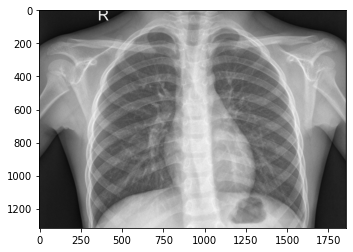

In [ ]:
img, label = dataset[0]
plt.imshow(img)

<h3><strong>Converting the images in the dataset into tensors</strong></h3>

<p>What tt.Resize does is that it resize the images from the dataset and make them equal sizes. This is a crucial part of data preparation because the deep learning model needs images with similar sizes for it to process the images in batches. The tt.CenterCrop crops the images ang make it focus on the center.</p>


In [ ]:
import torchvision.transforms as tt

In [ ]:
train_ds = ImageFolder(data_dir + "/train",tt.Compose([tt.Resize(224), tt.CenterCrop(224), tt.ToTensor()]))
test_ds = ImageFolder(data_dir + "/test",tt.Compose([tt.Resize(224), tt.CenterCrop(224), tt.ToTensor()]))
val_ds = ImageFolder(data_dir + "/val",tt.Compose([tt.Resize(224), tt.CenterCrop(224), tt.ToTensor()]))

<h3><strong>Checking the length of each set</strong></h3>

<strong>No. of images in the Traing Set</strong>

In [ ]:
len(train_ds)

5216

<strong>No. of images in the Test Set</strong>

In [ ]:
len(test_ds)

624

I forgot to count the validation set but you'll see it later

In [ ]:
len(train_ds)

5216

<strong>This is an example of an image found in the Training Set after being converted into tensor.</strong>

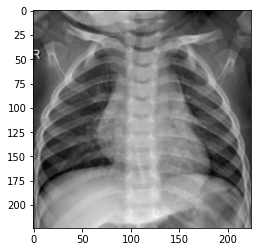

In [ ]:
img, label = train_ds[1]

plt.imshow(img.permute((1,2,0)))

<h3><strong>Creating Data Loader</strong></h3>


In [ ]:
from torch.utils.data import DataLoader
batch_size = 10

train_dl = DataLoader(train_ds, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=4, 
                      pin_memory=True)
val_dl = DataLoader(val_ds, 
                    batch_size, 
                    num_workers=4, 
                    pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


<h3><strong>Visualize batch using "show_batch" function</strong></h3>
<p>Remember that we set the batch size into 10 so the expected number of images here is 10.</p>

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


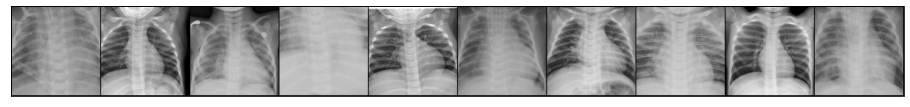

In [ ]:
show_batch(train_dl)

<h3><strong>To check the no. of images in each class</strong></h3>

In [ ]:
for cls in os.listdir(data_dir):
    PNEUMONIA_LEN = len(os.listdir(data_dir + "/" + cls + "/" + "PNEUMONIA"))
    NORMAL_LEN = len(os.listdir(data_dir + "/" + cls + "/" + "NORMAL"))
    print(cls, ":", PNEUMONIA_LEN)
    print(cls, ":", NORMAL_LEN)
    print("total",cls,":", PNEUMONIA_LEN + NORMAL_LEN)



train : 3875
train : 1341
total train : 5216
val : 8
val : 8
total val : 16
test : 390
test : 234
total test : 624


<p>Training set has a total of 5216. Validation set has a total of 16. Training set has a total of 624.</p>

<h3><strong>Utility Functions and Classes</strong></h3>

<h3><strong>GPU Utilities</strong></h3>


<p>The idea here is that if the GPU is avalilabe that will be used as a device to process the computation or else the CPU will be used</p>

In [ ]:
import torch
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
torch.cuda.is_available()

True

<p>Based on the output above, the machine being used has a GPU so it will be used for the heavy computation task.</p> 

In [ ]:
device = get_default_device()

In [ ]:
device

device(type='cuda')

0


torch.Size([3, 224, 224])

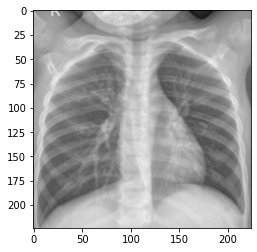

In [ ]:
# just checking
img, label = test_ds[5]
plt.imshow(img.permute((1,2,0)))
print(label)
img.shape

In [ ]:
img.device

device(type='cpu')


<p>In this part, we will transfer the data loader from CPU to GPU so the computation during training will happen there.</p>

In [ ]:
img_gpu = to_device(img, device)
img_gpu.device

device(type='cuda', index=0)

In [ ]:

train_dl = DeviceDataLoader(train_dl, device )
val_dl = DeviceDataLoader(val_dl, device)
print(train_dl.device, val_dl.device)

cuda cuda


<h3><strong>Model and Training Utilities</strong></h3>

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        "calculate loss for a batch of training data"
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        "calculate loss & accuracy for a batch of validation data"
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    "Evaluate the models performance on the validation set"
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

<h3><strong>Model (ResNet9)</strong></h3>
<p>We will use the Convolutional Neural Networks with ResNet9 architecture.</p>

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input: 10 x x 3 x 224 x 224
        self.conv1 = conv_block(in_channels, 224) #Input: 10 x 224 x 224 x 224
        self.conv2 = conv_block(224, 128, pool=True) #Input: 10 x 128 x 112 x 112, feature map is reduced to 16 x 16 because pool is set to true
        self.res1 = nn.Sequential(conv_block(128, 128), #Input: 10 x  128 x 112 x 112
                                  conv_block(128, 128)) # 10 x 128 x 112 x 112
        
        self.conv3 = conv_block(128, 256, pool=True) # 10 x 256 x 28 x 28
        self.conv4 = conv_block(256, 512, pool=True) # 10 x 512 x 14 x 14
        self.res2 = nn.Sequential(conv_block(512, 512), # 10 x 512 x 14 x 14
                                  conv_block(512, 512)) # 10 x 512 x 14 x 14
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 10 x 512 x 1 x 1
                                        nn.Flatten(), # 10 x 512
                                        nn.Dropout(0.2), # . Dropout makes the model learn by analyzing relationships not by specific values
                                        nn.Linear(512, num_classes))   
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(3, len(train_ds.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 224, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(224, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace

In [ ]:
# Checking if the weight of a layer is on cude
model.conv1[0].weight.device

device(type='cuda', index=0)

Pass one batch of input tensor through the model

In [ ]:
for batch in train_dl:
  images, label = batch
  print("images.shape",images.shape)
  print("images.device",images.device)
  preds = model(images)
  print("preds.shape", preds.shape)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape torch.Size([10, 3, 224, 224])
images.device cuda:0
preds.shape torch.Size([10, 2])


<h3><strong>Traing the Model</strong></h3>
<p>This is the part where the training will happen.</p>
<p>The variable "history" will store the necessary data in each epoch that needs to be monitored such as validation accuracy, validation loss and train loss.</p>


In [ ]:
history = [evaluate(model, val_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.4000000059604645, 'val_loss': 0.6957248449325562}]

In [ ]:
history += fit(5, 0.0001, model, train_dl, val_dl, torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.3636, val_loss: 0.6486, val_acc: 0.8000
Epoch [1], train_loss: 0.1942, val_loss: 0.8605, val_acc: 0.6500
Epoch [2], train_loss: 0.1503, val_loss: 0.7108, val_acc: 0.6500
Epoch [3], train_loss: 0.1244, val_loss: 0.4040, val_acc: 0.7000
Epoch [4], train_loss: 0.1027, val_loss: 0.6437, val_acc: 0.6500


In [ ]:
history += fit(5, 0.0001, model, train_dl, val_dl, torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.1266, val_loss: 0.7036, val_acc: 0.6500
Epoch [1], train_loss: 0.0989, val_loss: 0.2493, val_acc: 0.9167
Epoch [2], train_loss: 0.0886, val_loss: 0.1624, val_acc: 0.9500
Epoch [3], train_loss: 0.0718, val_loss: 0.2668, val_acc: 0.8000
Epoch [4], train_loss: 0.0682, val_loss: 0.3015, val_acc: 0.9000


In [ ]:
history += fit(5, 0.0001, model, train_dl, val_dl, torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.0712, val_loss: 0.5826, val_acc: 0.6500
Epoch [1], train_loss: 0.0544, val_loss: 0.2540, val_acc: 0.9000
Epoch [2], train_loss: 0.0539, val_loss: 1.0240, val_acc: 0.6500
Epoch [3], train_loss: 0.0337, val_loss: 0.1783, val_acc: 0.9500
Epoch [4], train_loss: 0.0392, val_loss: 0.1211, val_acc: 0.9500


In [ ]:
history += fit(5, 0.0001, model, train_dl, val_dl, torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.0301, val_loss: 0.1678, val_acc: 0.9500
Epoch [1], train_loss: 0.0408, val_loss: 0.5458, val_acc: 0.8000
Epoch [2], train_loss: 0.0322, val_loss: 0.1698, val_acc: 0.9000
Epoch [3], train_loss: 0.0209, val_loss: 0.4599, val_acc: 0.8000
Epoch [4], train_loss: 0.0200, val_loss: 0.1437, val_acc: 0.9167


In [ ]:
history += fit(5, 0.0001, model, train_dl, val_dl, torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.0179, val_loss: 0.1549, val_acc: 0.8667
Epoch [1], train_loss: 0.0227, val_loss: 0.2939, val_acc: 0.8500
Epoch [2], train_loss: 0.0122, val_loss: 0.0766, val_acc: 1.0000
Epoch [3], train_loss: 0.0279, val_loss: 1.3556, val_acc: 0.6500
Epoch [4], train_loss: 0.0197, val_loss: 0.0806, val_acc: 0.9500


In [ ]:
history += fit(5, 0.0001, model, train_dl, val_dl, torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.0193, val_loss: 0.3184, val_acc: 0.8000
Epoch [1], train_loss: 0.0172, val_loss: 0.3710, val_acc: 0.8500
Epoch [2], train_loss: 0.0082, val_loss: 0.2256, val_acc: 0.9000
Epoch [3], train_loss: 0.0210, val_loss: 0.9064, val_acc: 0.7500
Epoch [4], train_loss: 0.0116, val_loss: 0.3520, val_acc: 0.8500


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Figure 1: Accuracy vs. No. of epochs');

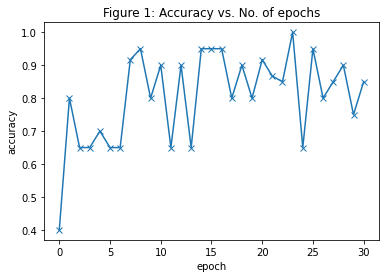

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Figure 2: Loss vs. No. of epochs');

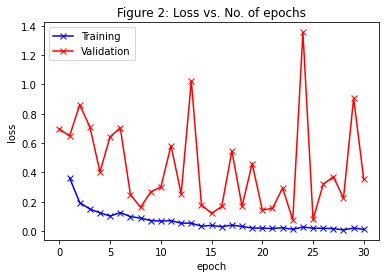

In [ ]:
plot_losses(history)

<h3><strong>Discussion</strong></h3><br>
From figure 1, we can see that even though the accuracy is jumping from somewhere in 65% to 80% and 80% to 95% it shows an increasing behaviour until the 23rd epoch where it already shows a decreasing value. From figure 2, validation loss still has no consistent behaviour but we can observe that it is somehow decreasing along with training loss untill the 23rd epoch where it's values starts to increase. The deep learning model presented in this notebook shows an overfitting due to the fact that validation loss is always higher than the training loss which can be improved by fixing some of the minor problems such as not adding the test set to training set and more.

<h3><strong>A brief explanation on how to analyze the losses and accuracy during training</strong></h3>

I will just leave it here for the reference. 
Link: https://stackoverflow.com/questions/48226086/training-loss-and-validation-loss-in-deep-learning

In machine learning and deep learning there are basically three cases

1) Underfitting

This is the only case where loss > validation_loss, but only slightly, if loss is far higher than validation_loss, please post your code and data so that we can have a look at

2) Overfitting

loss << validation_loss

This means that your model is fitting very nicely the training data but not at all the validation data, in other words it's not generalizing correctly to unseen data

3) Perfect fitting

loss == validation_loss

If both values end up to be roughly the same and also if the values are converging (plot the loss over time) then chances are very high that you are doing it right

<h3><strong>Saving the Results on Jovian</strong></h3>

In [ ]:
history[-1]

{'train_loss': 0.011585911735892296,
 'val_acc': 0.8500000238418579,
 'val_loss': 0.3520486652851105}

In [ ]:
jovian.reset()
jovian.log_dataset(image_size=224)
jovian.log_hyperparams(batch_size=10,
                       arch="Resnet9",
                       epochs=[5,5,5,5,5,5],
                       lrs=[0.0001,0.0001,0.0001,0.0001,0.0001,0.0001],
                       opt=["Adam","Adam","Adam","Adam","Adam","Adam"])
jovian.log_metrics(train_loss=history[-1]["train_loss"],
                   val_acc=history[-1]["val_acc"],
                   val_loss=history[-1]["val_loss"])

[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Dataset logged.
[jovian] Hyperparams logged.
[jovian] Metrics logged.
